# Basic examples

In this notebook we will show how to compute correlation functions with various binning schemes of survey and periodic data, how to dump them to disk, etc.
You need to have installed **pycorr** with:
```
python -m pip install git+https://github.com/adematti/pycorr#egg=pycorr[corrfunc]
```

In [1]:
import os
import tempfile
import numpy as np
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, NaturalTwoPointEstimator, LandySzalayTwoPointEstimator,\
                   project_to_multipoles, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=1000., n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [offset + rng.uniform(0., 1., size)*b for b in boxsize]
        weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, that will take care of computing pair counts.

### Survey data

For survey data, we will use the Landy-Szalay estimator.

In [4]:
# Compute the s-mu cross-correlation function, with 50 bins between 1e-9 (to remove self-pairs)
# and 100 mu-bins between 0 and 1, using Corrfunc and 4 OpenMP threads
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)

[000000.03]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000000.03]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000000.74]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000001.46]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D2R1.
[000002.16]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


In [5]:
# s and weighted counts can be obtained through:
print(result.sep.shape, result.corr.shape)

(50, 100) (50, 100)


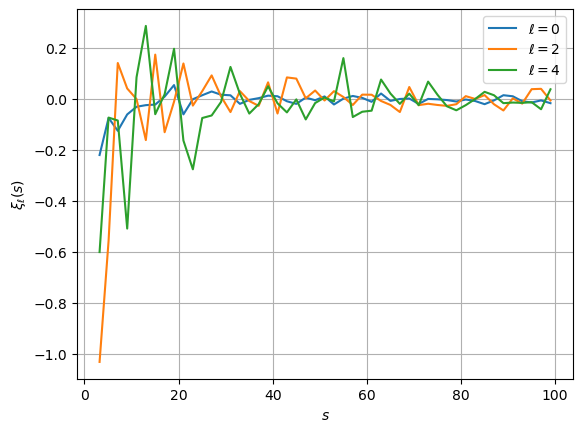

In [6]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = project_to_multipoles(result, ells=ells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Flat, as expected

In [7]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = LandySzalayTwoPointEstimator.load(fn)

[000003.62]  10-12 20:17  LandySzalayTwoPointEstimator INFO     Saving /tmp/tmp5ghwadao/tmp.npy.
[000003.62]  10-12 20:17  LandySzalayTwoPointEstimator INFO     Loading /tmp/tmp5ghwadao/tmp.npy.


In [8]:
# You can reuse a precomputed R1R2 result.R1R2
result2 = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                      data_positions2=data_positions2, data_weights2=data_weights2,
                                      randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                      randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                      engine='corrfunc', R1R2=result.R1R2, nthreads=4)
mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000003.63]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000003.63]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000004.13]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000004.84]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D2R1.
[000005.55]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using precomputed pair counts R1R2.


[000005.57]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000005.57]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000005.61]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000005.68]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D2R1.
[000005.75]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


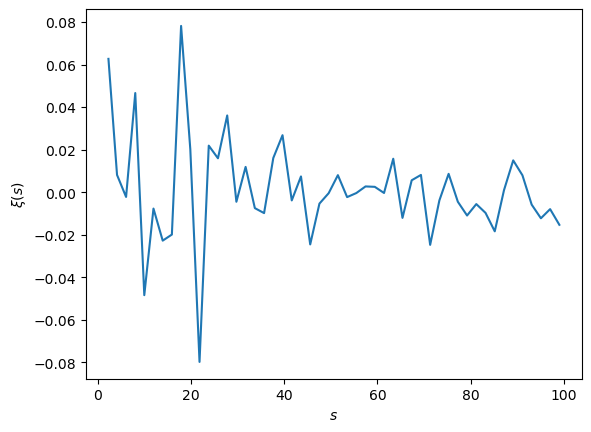

In [9]:
# Other binning are "s", "rppi"
edges = np.linspace(1, 100, 51)
result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi(s)$')
plt.show()

[000006.08]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000006.08]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000006.20]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000006.31]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


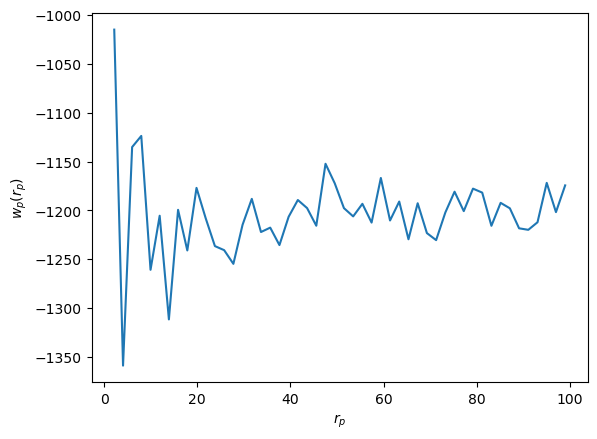

In [10]:
# Here we compute rp-pi auto-correlation
edges = (np.linspace(1, 100, 51), np.linspace(0, 50, 51))
result = TwoPointCorrelationFunction('rppi', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
wp = np.sum(result.corr*np.diff(result.edges[-1]), axis=-1)
sep = np.mean(result.sep, axis=-1)
ax.plot(sep, wp)
ax.set_xlabel('$r_{p}$')
ax.set_ylabel(r'$w_{p}(r_{p})$')
plt.show()

[000006.72]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000006.72]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000006.87]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000007.00]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


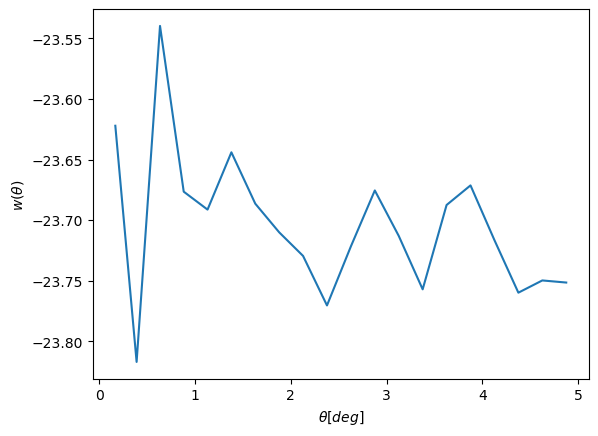

In [11]:
# Here we compute angular auto-correlation, without weights
# we provide cartesian positions instead of RA/Dec, so say position_type='xyz'
edges = np.linspace(1e-4, 5, 21)
result = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', position_type='xyz', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel(r'$\theta [deg]$')
ax.set_ylabel(r'$w(\theta)$')
plt.show()

### Periodic box data

For periodic box data, we will use the natural estimator. Syntax with the high-level interface is the same.

[000010.37]  10-12 20:17  TwoPointCorrelationFunction  INFO     Using estimator NaturalTwoPointEstimator.
[000010.37]  10-12 20:17  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000010.61]  10-12 20:17  TwoPointCorrelationFunction  INFO     Analytically computing pair counts R1R2.


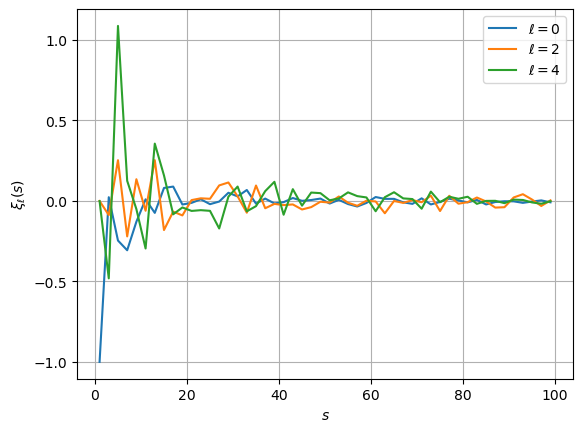

In [12]:
# Compute the s-mu correlation function, with 50 bins between 1e-9 (to remove self-pairs)
# and 100 mu-bins between 0 and 1, using Corrfunc and 4 OpenMP threads
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
boxsize = 1000.
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1,
                                     engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = project_to_multipoles(result, ells=ells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Flat, as expected

## Pair counters

Same results can be obtained directly from pair counters, e.g. for the last correlation function estimation.

In [13]:
from pycorr import TwoPointCounter, AnalyticTwoPointCounter, BaseTwoPointCounter, NaturalTwoPointEstimator
D1D2 = TwoPointCounter('smu', edges, positions1=data_positions1,
                       engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)
R1R2 = AnalyticTwoPointCounter('smu', edges, boxsize=boxsize)

# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    D1D2.save(fn)
    # And reload the result
    D1D2 = BaseTwoPointCounter.load(fn)

result2 = NaturalTwoPointEstimator(D1D2=D1D2, R1R2=R1R2)
mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000011.09]  10-12 20:17  CorrfuncTwoPointCounter      INFO     Saving /tmp/tmp9b3zmbly/tmp.npy.
[000011.09]  10-12 20:17  BaseTwoPointCounter          INFO     Loading /tmp/tmp9b3zmbly/tmp.npy.
